<Axes: xlabel='Date'>

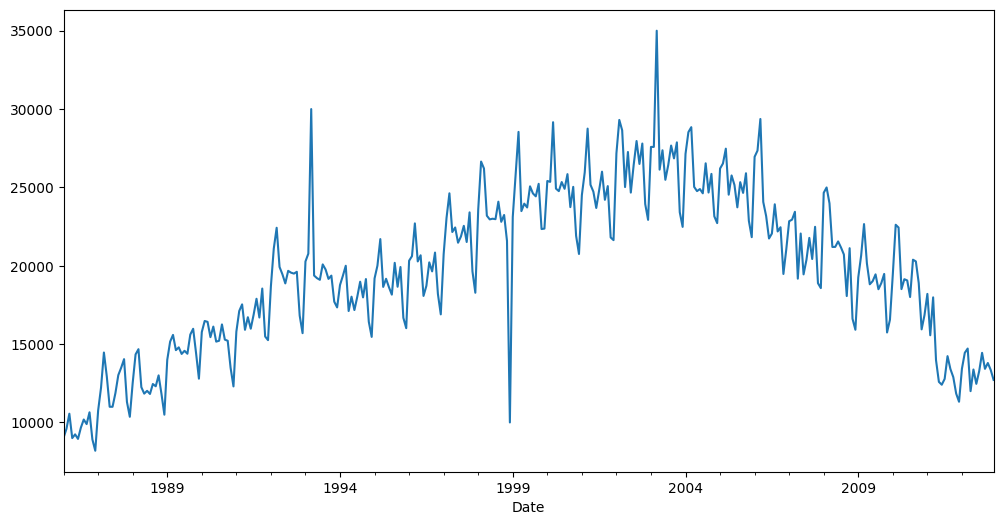

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

anomaly_data = pd.read_csv('../data/anomaly_data.csv')
anomaly_data.Date = pd.to_datetime(anomaly_data.Date, format='%Y-%m-%d')
anomaly_data.set_index('Date', inplace=True)

anomaly_data.loc['1998-12-01', 'Total'] = 10000
anomaly_data.loc["1993-3-1"]['Total'] = 30000
anomaly_data.loc["2003-3-1"]['Total'] = 35000

anomaly_data.Total.plot(figsize=(12, 6))


<Axes: xlabel='Date'>

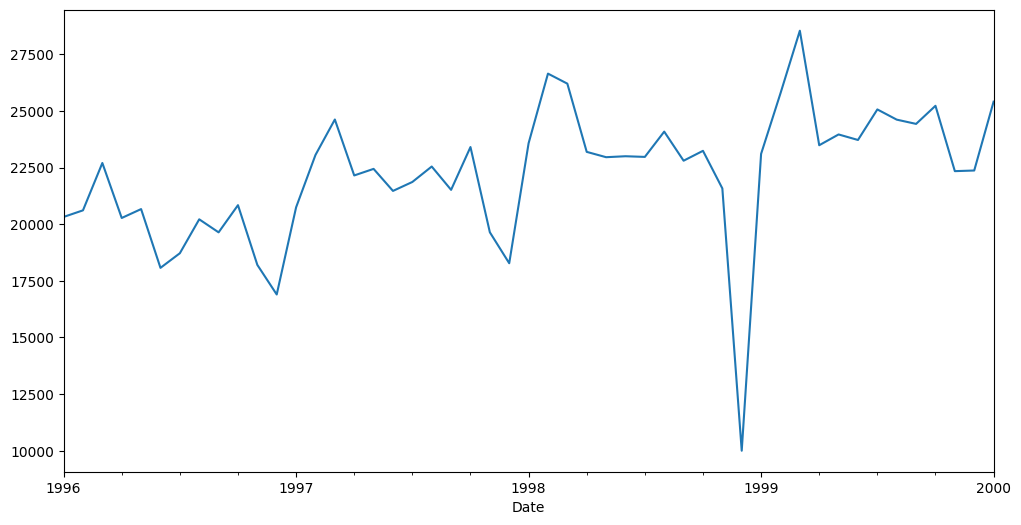

In [2]:
lim_anomaly_data = anomaly_data.loc['1996-01-01': '2000-01-01']
lim_anomaly_data.Total.plot(figsize=(12, 6))


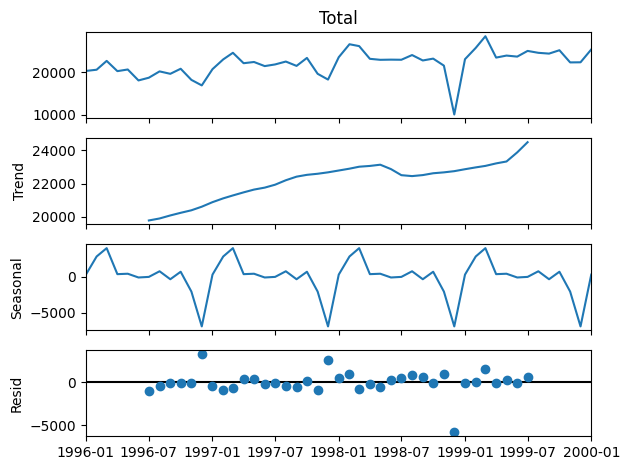

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(lim_anomaly_data.Total, model='additive')
fig = result.plot()


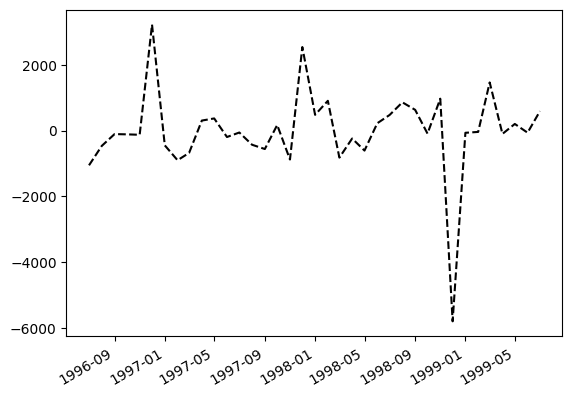

In [4]:
fig, ax = plt.subplots()
x = result.resid.index
y = result.resid.values
ax.plot_date(x, y, '--', color='black')
fig.autofmt_xdate()


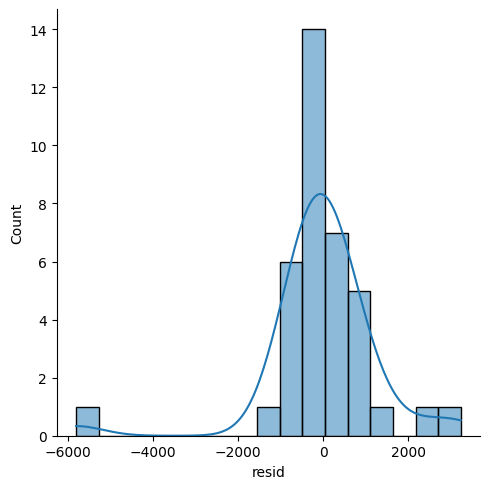

In [5]:
sns.displot(result.resid, kde=True)

<Axes: >

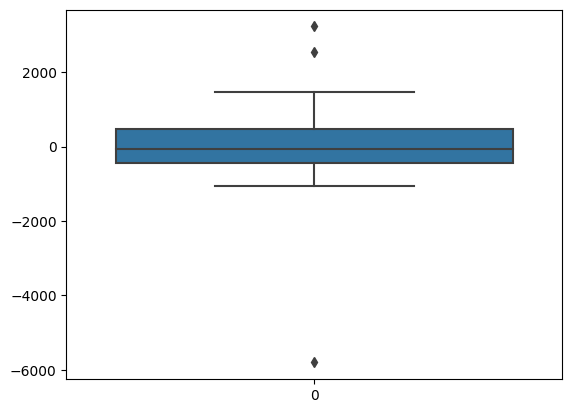

In [6]:
sns.boxplot(result.resid)

<Axes: xlabel='Date'>

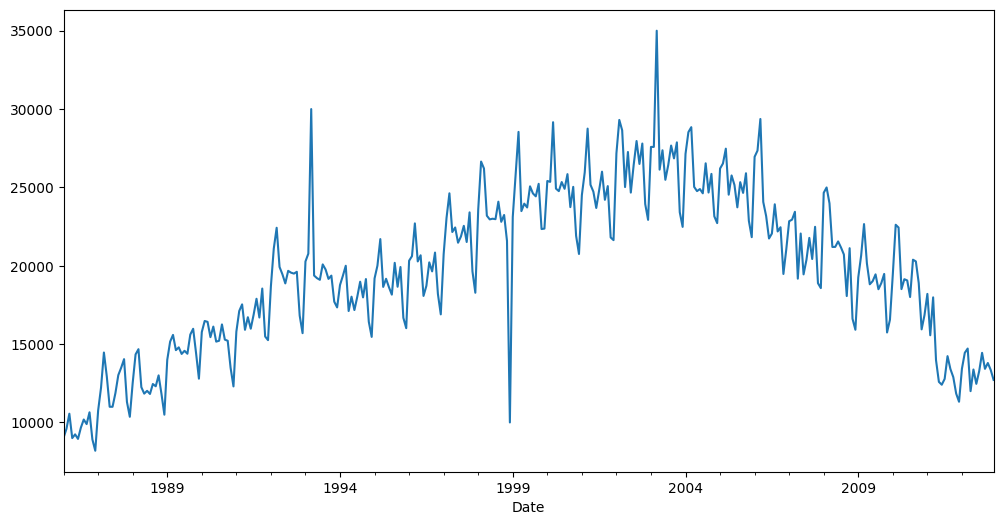

In [7]:
anomaly_data.Total.plot(figsize=(12, 6))

In [9]:
import numpy as np
import pandas as pd
from scipy.stats import t
from statsmodels.tsa.seasonal import seasonal_decompose


In [10]:
result = seasonal_decompose(lim_anomaly_data.Total, model='additive')
residuals = result.resid.dropna()  # discard missing values


In [11]:
def t_ESD_test(residuals, max_outliers):
    test_statistics = []
    anomalies = []
    for i in range(max_outliers):
        residuals_mean, residuals_std = np.mean(residuals), np.std(residuals)
        z_scores = (residuals - residuals_mean) / residuals_std
        max_z_score = np.max(np.abs(z_scores))
        max_z_index = np.argmax(np.abs(z_scores))
        test_statistic = (len(residuals) - 1) * max_z_score / np.sqrt((len(residuals) - 2 + max_z_score**2) * len(residuals))
        critical_value = t.ppf(1 - 0.05 / (2 * len(residuals)), len(residuals) - 2)
        if test_statistic > critical_value:
            anomalies.append(residuals.index[max_z_index])
            residuals = residuals.drop(residuals.index[max_z_index])
            test_statistics.append(test_statistic)
        else:
            break
    return anomalies, test_statistics


In [12]:
anomalies, test_statistics = t_ESD_test(residuals, max_outliers=10)

anomaly
 1    320
-1      4
Name: count, dtype: int64


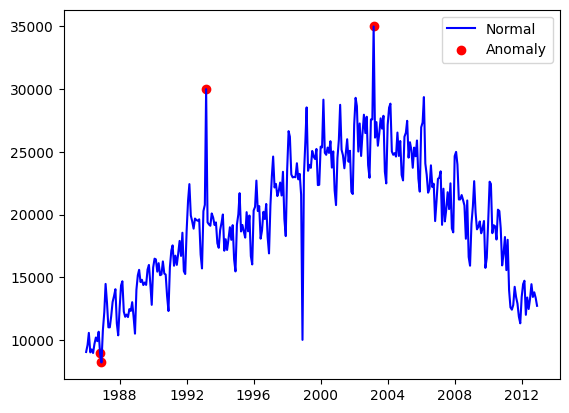

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Define the proportion of outliers expected (contamination)
outliers_fraction = 0.01

# Standardize the data
scaler = StandardScaler()
np_scaled = scaler.fit_transform(anomaly_data)
data = pd.DataFrame(np_scaled)

# Define and fit the model
model = IsolationForest(contamination=outliers_fraction)
model.fit(data)

# Make predictions (-1 indicates anomalies)
anomaly_data['anomaly'] = model.predict(data)
print(anomaly_data.anomaly.value_counts())

# Plot data and anomalies
fig, ax = plt.subplots()
anomalies = anomaly_data[anomaly_data['anomaly'] == -1]
ax.plot(anomaly_data.index, anomaly_data.Total, color='blue', label = 'Normal')
ax.scatter(anomalies.index, anomalies.Total, color='red', label = 'Anomaly')
plt.legend()
plt.show()


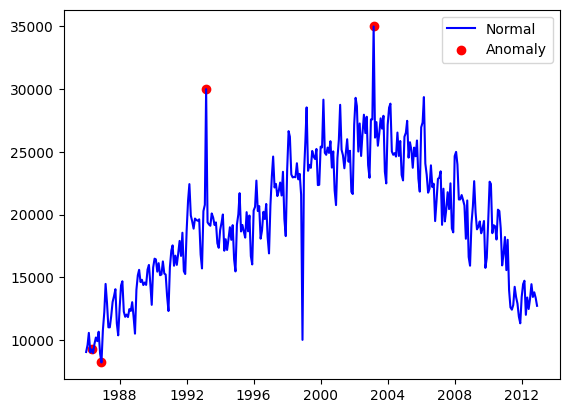

In [14]:
# Fine-tuning the Isolation Forest
model = IsolationForest(contamination=outliers_fraction, n_estimators=200, max_samples='auto')
model.fit(data)
anomaly_data['anomaly'] = model.predict(data)

# Plot data and anomalies
fig, ax = plt.subplots()
anomalies = anomaly_data[anomaly_data['anomaly'] == -1]
ax.plot(anomaly_data.index, anomaly_data.Total, color='blue', label = 'Normal')
ax.scatter(anomalies.index, anomalies.Total, color='red', label = 'Anomaly')
plt.legend()
plt.show()


In [81]:
from statsforecast import StatsForecast
from statsforecast.models import AutoETS

anomaly_data = pd.read_csv('../data/anomaly_data.csv')
anomaly_data.Date = pd.to_datetime(anomaly_data.Date, format='%Y-%m-%d')
anomaly_data.set_index('Date', inplace=True)

anomaly_data.loc['1998-12-01', 'Total'] = 10000
anomaly_data.loc["1993-3-1"]['Total'] = 30000
anomaly_data.loc["2003-3-1"]['Total'] = 35000

nixtla_df = anomaly_data.copy().reset_index()
nixtla_df.rename(columns = {'Date': 'ds', 'Total': 'y'}, inplace = True)
nixtla_df['unique_id'] = 'all'

In [86]:
models = [AutoETS(season_length=12)]
sf = StatsForecast(models = models, freq='M')
sf.fit(nixtla_df)

StatsForecast(models=[AutoETS])

In [87]:
forecast_df = sf.forecast(df=nixtla_df, level= [99], h = 6, fitted=True)
forecast_df

/Users/guilhermediaz-berrio/.pyenv/versions/3.11.3/envs/book-mkt-analytics/lib/python3.11/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,AutoETS,AutoETS-lo-99,AutoETS-hi-99
unique_id,,,,
all,2012-12-31,15672.202148,12932.765625,18411.638672
all,2013-01-31,16596.990234,13432.706055,19761.273438
all,2013-02-28,18095.798828,14436.110352,21755.488281
all,2013-03-31,14610.625000,11140.436523,18080.812500
all,2013-04-30,14999.777344,11286.677734,18712.876953
all,2013-05-31,14395.107422,10559.337891,18230.876953


In [88]:
insample_forecasts = sf.forecast_fitted_values().reset_index()
anomalies = insample_forecasts.loc[(insample_forecasts['y'] >= insample_forecasts['AutoETS-hi-99']) | (insample_forecasts['y'] <= insample_forecasts['AutoETS-lo-99'])]
anomalies

/Users/guilhermediaz-berrio/.pyenv/versions/3.11.3/envs/book-mkt-analytics/lib/python3.11/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,unique_id,ds,y,AutoETS,AutoETS-lo-99,AutoETS-hi-99
86,all,1993-03-01,30000.0,21621.250000,18150.146484,25092.353516
87,all,1993-04-01,19377.0,23516.269531,20045.166016,26987.373047
155,all,1998-12-01,10000.0,20363.175781,16892.072266,23834.279297
156,all,1999-01-01,23107.0,19123.447266,15652.342773,22594.550781
157,all,1999-02-01,25780.0,22082.537109,18611.433594,25553.640625
158,all,1999-03-01,28544.0,25054.363281,21583.259766,28525.466797
206,all,2003-03-01,35000.0,29587.054688,26115.951172,33058.160156
301,all,2011-02-01,15564.0,20473.115234,17002.011719,23944.218750


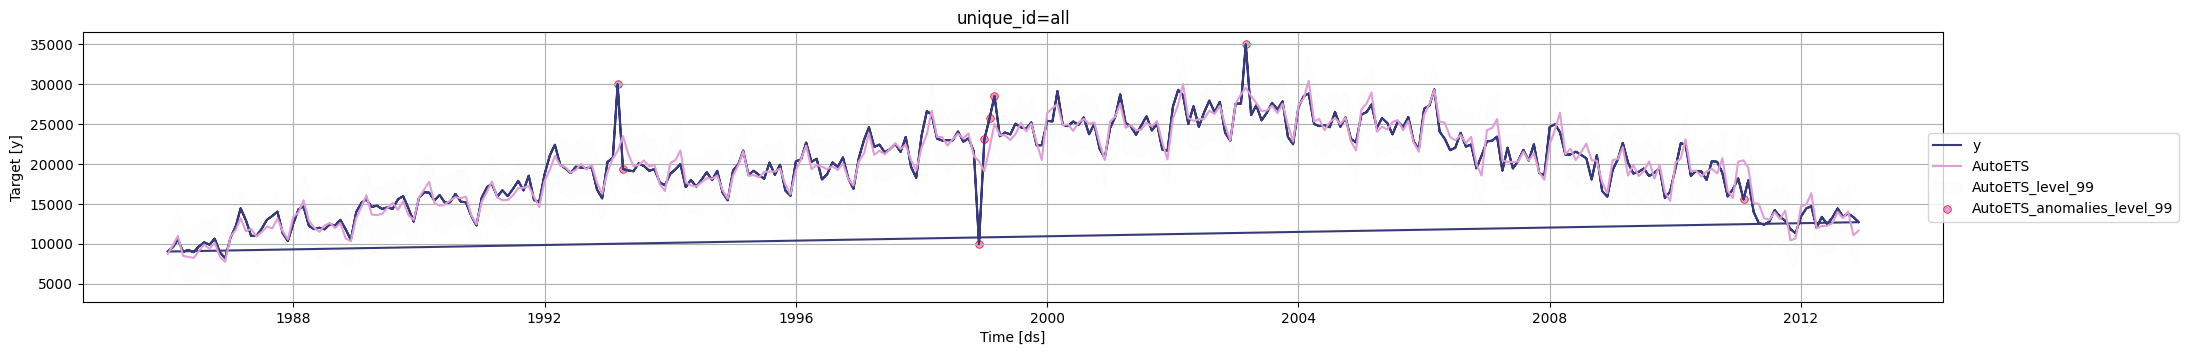

In [89]:
sf.plot(nixtla_df, forecasts_df=insample_forecasts, plot_anomalies = True, level=[99])

<Axes: >

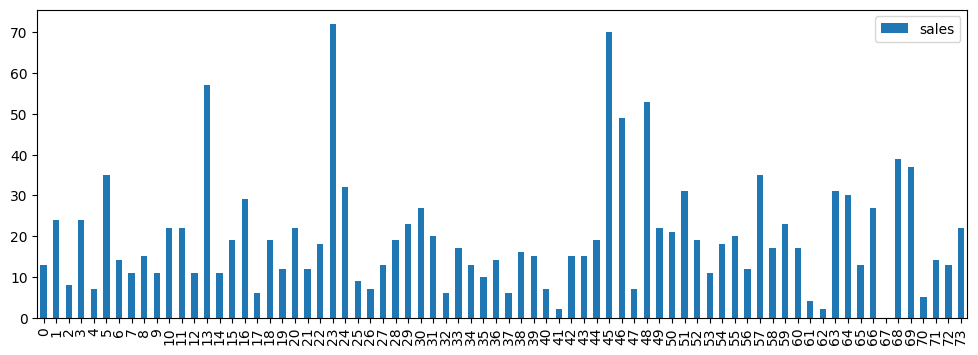

In [21]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd

# Load daily sales data
daily_sales = pd.read_csv('../data/anomaly_daily_sales.csv')
daily_sales.rename(columns={0: 'sales'}, inplace=True)

# Plot daily sales
daily_sales.plot(figsize=(12, 4), kind='bar')


In [16]:
# Define the model
with pm.Model() as model_pymc:
    alpha = 1.0/daily_sales.sales.mean()  

    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)

    tau = pm.DiscreteUniform("tau", lower=0, upper=len(daily_sales.sales)-1)

    idx = np.arange(len(daily_sales.sales)) 
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

    observed = pm.Poisson("observed", lambda_, observed=daily_sales.sales)

# Draw samples
with model_pymc:
    trace = pm.sample(10000, tune=5000)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_1, lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 4 seconds.


<Axes: >

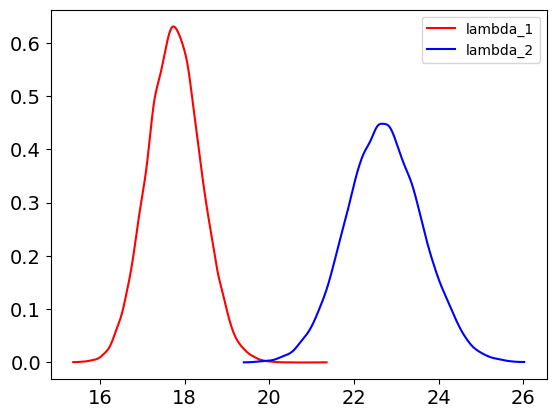

In [17]:
# Extract samples
lambda_1_samples = trace.posterior['lambda_1']
lambda_2_samples = trace.posterior['lambda_2']
tau = trace.posterior['tau']

# Plot distributions
az.plot_dist(lambda_1_samples, label='lambda_1', color='red')
az.plot_dist(lambda_2_samples, label='lambda_2', color='blue')


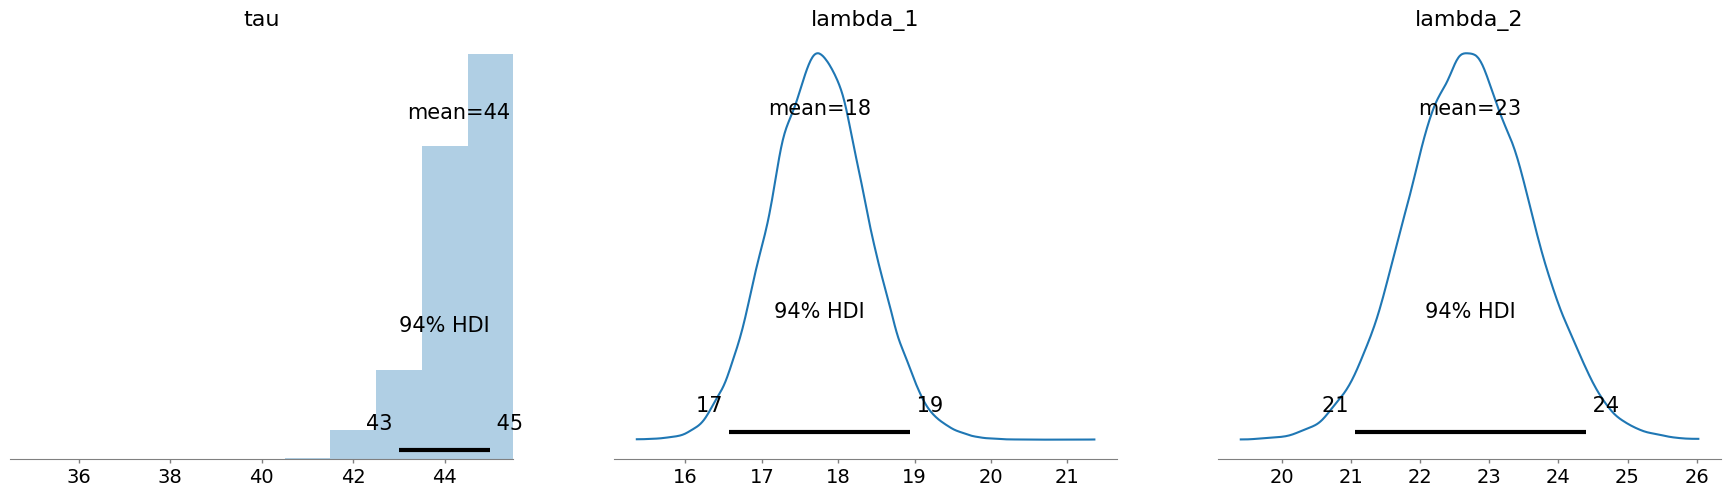

In [18]:
# Plot posterior
az.plot_posterior(trace);
